<a href="https://colab.research.google.com/github/Zkeera/Project-Klasifikasi-Gambar/blob/main/Project_Klasifikasi_Gambar_Mohammad_Taqi_Ashiddiqi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Dataset Gambar Merak
- **Nama:** [Mohammad Taqi Ashiddiqi]
- **Email:** [mohammadtaqi029@gmail.com]
- **ID Dicoding:** [MC361D5Y0526]

## Import Semua Packages/Library yang Digunakan

In [5]:
!pip install tensorflowjs
import gdown
import zipfile
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflowjs as tfjs
import ydf

## Data Preparation

### Data Loading

In [9]:
# URL Google Drive (ambil ID file dari URL)
file_url = 'https://drive.google.com/uc?id=1uK8BfyWRb4tVCoC_7BjP87cI0JUxvdvj'

# Tentukan path tempat menyimpan file
output_path = '/mnt/data/Dataset_Merak.zip'

output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

# Mengunduh file dari Google Drive
gdown.download(file_url, output_path, quiet=False)

# Ekstrak file ZIP yang telah diunduh
extracted_folder_path = '/mnt/data/Dataset_Merak/'
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# List isi folder setelah ekstraksi
extracted_files = os.listdir(extracted_folder_path)
print("Isi folder setelah ekstraksi:", extracted_files)

Downloading...
From (original): https://drive.google.com/uc?id=1uK8BfyWRb4tVCoC_7BjP87cI0JUxvdvj
From (redirected): https://drive.google.com/uc?id=1uK8BfyWRb4tVCoC_7BjP87cI0JUxvdvj&confirm=t&uuid=e2cf9a24-3502-430e-9768-be0052c58332
To: /mnt/data/Dataset_Merak.zip
100%|██████████| 109M/109M [00:01<00:00, 83.3MB/s] 


Isi folder setelah ekstraksi: ['Dataset Merak']


### Data Preprocessing

#### Split Dataset

In [10]:
# Tentukan path folder dataset setelah ekstraksi
dataset_dir = os.path.join(extracted_folder_path, 'Dataset Merak')

# Membaca gambar-gambar dalam folder dataset
image_files = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg')]

# Membuat label untuk dataset: anggap semua gambar adalah 'peacock' (label 1)
labels = np.ones(len(image_files))

# Split data menjadi train, validation, dan test set (80% train, 10% validation, 10% test)
train_files, test_files, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.1, random_state=42)

# Fungsi untuk meng-load gambar
def load_images_and_labels(file_list, labels, directory):
    images = []
    for file in file_list:
        img_path = os.path.join(directory, file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalisasi gambar
        images.append(img_array)
    return np.array(images), np.array(labels)

# Load data untuk training, validation, dan testing dengan label
train_images, train_labels = load_images_and_labels(train_files, train_labels, dataset_dir)
val_images, val_labels = load_images_and_labels(val_files, val_labels, dataset_dir)
test_images, test_labels = load_images_and_labels(test_files, test_labels, dataset_dir)

print(f'Total train images: {len(train_images)}')
print(f'Total validation images: {len(val_images)}')
print(f'Total test images: {len(test_images)}')


Total train images: 1191
Total validation images: 133
Total test images: 332


## Modelling

### Mempersiapkan Augmentasi Data

In [11]:
# Setup ImageDataGenerator untuk augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi gambar
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator untuk training, validation, dan test data
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

### Membangun Model CNN

In [13]:
# Membangun model CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Untuk klasifikasi dua kelas (peacock vs not peacock)
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Melatih Model

In [14]:
# Menambahkan callback untuk early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Melatih model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 32,  # Menghitung jumlah batch
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_images) // 32,  # Menghitung jumlah batch validasi
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 1.0000 - loss: 0.1676 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
 1/37 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


## Evaluasi dan Visualisasi

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Accuracy: 1.0


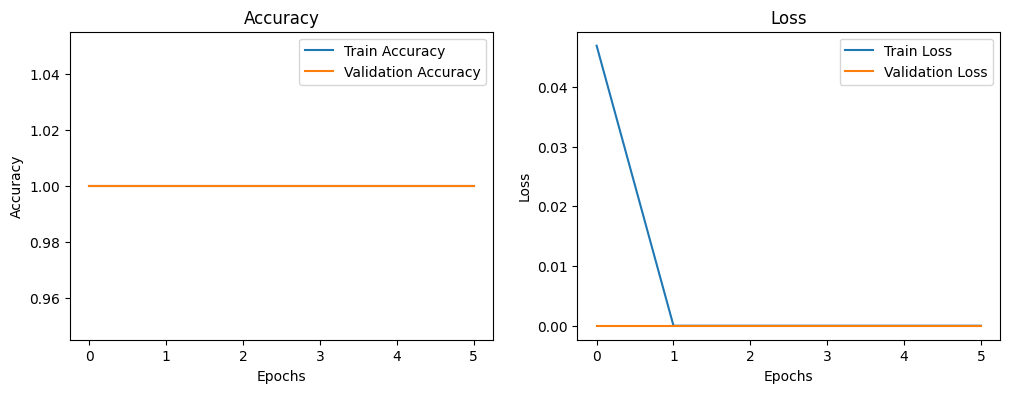

In [15]:
# Evaluasi model
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_images) // 32)
print(f'Test Accuracy: {test_acc}')

# Plot akurasi dan loss selama pelatihan
plt.figure(figsize=(12, 4))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,102,533 (217.83 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,068,356 (145.22 MB)

## Konversi Model

In [17]:
# Menyimpan model dalam format SavedModel (TensorFlow)
model.export('/mnt/data/peacock_model_savedmodel')  # Format SavedModel dengan folder

Saved artifact at '/mnt/data/peacock_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139852325645264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325645840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325646416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325646992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325646224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325647760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325646032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325647568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325648528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325649488: TensorSpec(shape=(), dtype=tf.resource, name=N

In [20]:
# Menyimpan model dalam format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('/mnt/data/peacock_model_tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpuu3uueqb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139852325645264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325645840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325646416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325646992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325646224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325647760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325646032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325647568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325648528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139852325649488: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [19]:
# Menyimpan model dalam format TFJS (TensorFlow.js)
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, '/mnt/data/peacock_model_tfjs')

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)